In [1]:
from matplotlib import pyplot as plt
from matplotlib import cm as cm
import pandas as pd
import networkx as nx
import numpy as np
import itertools
import random
import time
import json
import math

In [2]:
import sage.all
from sage.graphs.graph import Graph

In [3]:
import sys
import os

In [4]:
script_dir = os.path.abspath('./algorithms/')
sys.path.append(script_dir)

In [5]:
import brute_force as bf
import genetic_algorithms as ga
import s_metaheuristics as sm
import interval_graph_check as igc
import particle_swarm_optimization as pso

In [6]:
def read_graphs_from_json(json_file):
    with open(json_file, 'r') as file:
        return json.load(file)

# Brute force - plot

In [7]:
gA =  [(0, 1), (1, 2), (1, 5), (2, 3), (2, 6), (3, 4), (3, 7), (5, 6), (6, 7), (7, 8)]
gB = [(0, 1), (0, 3), (0, 6), (1, 2), (1, 3), (1, 4), (1, 6), (2, 4), (2, 6), (3, 4), (3, 5), (3, 6), (4, 5), (6, 7)]

In [8]:
def plot_bf(name, G, output_folder):
    
    results = []
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))

    start_time = time.time()
    added_edges, G_minimal = bf.brute_force_min_interval_completion(G)
    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Graph: {name}")
    
    # Prepare the .txt file for results
    os.makedirs(output_folder, exist_ok=True)
    results_file_path = os.path.join(output_folder, f'bf_results_{name}.txt')
    
    best_value = len(added_edges) if added_edges is not None else None
    
    with open(results_file_path, 'w') as f:
        if added_edges is None:
            print("Initial graph is already an interval graph")
            f.write("Initial graph is already an interval graph\n")
        else:
            print(f"Added edges: {added_edges}")
            f.write(f"Added edges: {added_edges}\n")
            print(f"Best value: {best_value}")
            f.write(f"Best value : {best_value}\n")
            
        print(f"Execution time: {elapsed_time:.4f} s")
        f.write(f"Execution time: {elapsed_time:.4f} s\n")
        print("\n")

        # Plotting initial graph
        plot_G = G.plot(figsize=(8, 8), vertex_size=500, edge_color='blue', graph_border=False)

        # Plotting modified graph
        if added_edges is None:
            plot_G_min = G.plot(figsize=(8, 8), vertex_size=500, edge_color='blue', graph_border=False)
        else:
            plot_G_min = G_minimal.plot(figsize=(8, 8), vertex_size=500, edge_color='red', graph_border=False)

        # Adding graphs to subplots
        plot_G.matplotlib(figure=fig, sub=ax[0])
        ax[0].set_title(f"Initial Graph: {name}")
        ax[0].axis('off')

        plot_G_min.matplotlib(figure=fig, sub=ax[1])
        ax[1].set_title(f"Modified Graph: {name}")
        ax[1].axis('off')

        plt.subplots_adjust(wspace=0.5, hspace=0.5)
        plot_file_path = os.path.join(output_folder, f'bf_plot_{name}.png')
        plt.savefig(plot_file_path, bbox_inches='tight', facecolor='white')
        plt.close()
            
            
        result = {
            'Graph' : name,
            'Algorithm': "Brute Force",
            'Best Value': best_value,
            'Execution Time': elapsed_time
        }    
        
        return result

In [9]:
def process_graphs_bf(input_file, output_folder):
    
    graphs = read_graphs_from_json(input_file)
    results = []
    
    for graph_name, edges in graphs.items():

        print(f"Processing Graph: {graph_name}")
        G = Graph(edges)
        result = plot_bf(graph_name, G, output_folder)
        results.append(result)
        
    return results

# Simulated annealing - plot

In [10]:
def plot_sa(input_file, output_folder):

    graphs = read_graphs_from_json(input_file)
    
    results_text = []
    
    results = []

    for graph_name, edges in graphs.items():
        print(f"Processing graph: {graph_name}")
        start_time = time.time()
     
        G = Graph(edges)
        added_edges, G_minimal, values = sm.simulated_annealing(G, num_iters=50000)

        end_time = time.time()
        elapsed_time = end_time - start_time

        check, _ = igc.check_interval_graph(G_minimal)

        best_value = len(added_edges) if added_edges is not None else None
        
        if not check:
            print("No interval graph found")
            results_text.append(f'Graph: {graph_name}, No result found, Execution time: {elapsed_time:.4f} s\n')
            best_value = float('inf')
        else:
            if added_edges is None:
                print("Initial graph is already an interval graph")
                results_text.append(f'Graph: {graph_name}, Initial graph is an interval graph, '
                                    f'Execution time: {elapsed_time:.4f} s\n')
        
            else:
                print(f"Added edges: {added_edges}")
                results_text.append(f'Graph: {graph_name}, Added edges: {added_edges}, '
                                    f'Execution time: {elapsed_time:.4f},  Best value : {best_value}\n')
                
                print(f"Best value: {best_value}")
                
        plot_initial_and_modified_graph(G, G_minimal, added_edges, values, graph_name, output_folder)

        print(f"Execution time for {graph_name}: {elapsed_time:.4f} s")
        print("---------------------------------------------------------")
        
        result = {
            'Graph' : graph_name,
            'Algorithm': "Simulated Annealing",
            'Best Value': best_value,
            'Execution Time': elapsed_time
        } 
        
        results.append(result)
        
    os.makedirs(output_folder, exist_ok=True)

    results_file_path = os.path.join(output_folder, 'simulated_annealing_results.txt')
    with open(results_file_path, 'w') as f:
        f.writelines(results_text)
        

    return results

In [11]:
def plot_initial_and_modified_graph(G, G_minimal, added_edges, values, graph_name, output_folder):

    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    # Initial graph
    plot_G = G.plot(figsize=(8, 8), vertex_size=500, edge_color='blue', graph_border=False)
    plot_G.matplotlib(figure=fig, sub=axes[0])
    axes[0].set_title("Initial Graph")
    axes[0].axis('off')

    # Modified graph
    if added_edges is None:
        plot_G_min = G.plot(figsize=(8, 8), vertex_size=500, edge_color='blue', graph_border=False)
    else:
        plot_G_min = G_minimal.plot(figsize=(8, 8), vertex_size=500, edge_color='red', graph_border=False)
    plot_G_min.matplotlib(figure=fig, sub=axes[1])
    axes[1].set_title("Modified Graph")
    axes[1].axis('off')

    # Plotting the solution values
    if values and any(val is not None for val in values):
        clean_values = [val if val is not None else 0 for val in values]
        axes[2].plot(range(len(clean_values)), clean_values)
        axes[2].set_title('Simulated Annealing Progress')
        axes[2].set_xlabel('Steps')
        axes[2].set_ylabel('Solution Value')
        axes[2].set_ylim(bottom=0)
    else:
        axes[2].axhline(y=0, color='black', linestyle='--')
        axes[2].set_title('Simulated Annealing Progress (No Added Edges)')
        axes[2].set_xlabel('Steps')
        axes[2].set_ylabel('Solution Value')
        axes[2].set_ylim(bottom=0)

    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    plot_file_path = os.path.join(output_folder, f'simulated_annealing_{graph_name}.png')
    plt.savefig(plot_file_path, facecolor='white')
    plt.close()

# Simulated annealing - cooling plot

In [12]:
cooling_params = {
    't_max_values': [10000, 50000],  # Higher starting temperatures
    't_min': 0.1,                   # Smaller final temperature
    'step_max': 50000,                # More iterations
    'alpha': 0.8                     # Slower cooling
}

In [13]:
def plot_sa_cooling(G, cooling_params, output_folder, graph_name):
    print(f"Simulated annealing - cooling for graph: {graph_name}")
    
    cooling_methods = {
        'linear_multiplicative': sm.linear_multiplicative_cooling,
        'natural_log_exponential_multiplicative': sm.natural_log_exponential_multiplicative_cooling,
        'logarithmic_multiplicative': sm.logarithmic_multiplicative_cooling,
        'quadratic_multiplicative': sm.quadratic_multiplicative_cooling,
        'linear_additive': sm.linear_additive_cooling,
        'exponential_additive': sm.exponential_additive_cooling,
        'quadratic_additive': sm.quadratic_additive_cooling
    }

    t_max_values = cooling_params['t_max_values']
    t_min = cooling_params['t_min']
    step_max = cooling_params['step_max']
    alpha = cooling_params['alpha']

    ultimate_best_energy = float('inf')  # Initialize to infinity to track the global best energy
    best_cooling_method = None
    best_t_max = None
    best_time = None
    
    os.makedirs(output_folder, exist_ok=True)
    results_file_path = os.path.join(output_folder, f'sa_cooling_results_{graph_name}.txt')
    
    overall_start = time.time()
    
    with open(results_file_path, 'w') as f:
        check, _ = igc.check_interval_graph(G)

        if check:
            print('Graph is already an interval graph')
            f.write(f'Graph {graph_name} is already an interval graph.\n')
            ultimate_best_energy = 0
        else:
            fig, axs = plt.subplots(len(cooling_methods), len(t_max_values), figsize=(15, 15), sharex=True)
            fig.suptitle(f'Simulated Annealing Performance for {graph_name}')

            acceptance_rates = {t_max: [] for t_max in t_max_values}
            best_energies = {t_max: [] for t_max in t_max_values}
            labels = list(cooling_methods.keys())
            colors = plt.cm.viridis(np.linspace(0, 1, len(t_max_values)))

            for i, (name, cooling_func) in enumerate(cooling_methods.items()):
                for j, t_max in enumerate(t_max_values):
                    start_time = time.time()
                    
                    # Run simulated annealing with the specified cooling method
                    best_state, G_minimal, values, best_energy, acceptance_rate = sm.simulated_annealing_cooling(
                        G, cooling_func, t_max=t_max, t_min=t_min, step_max=step_max, alpha=alpha
                    )

                    end_time = time.time()
                    elapsed_time = end_time - start_time
                    
                    # Check if this is the best energy overall
                    if best_energy < ultimate_best_energy:
                        ultimate_best_energy = best_energy
                        best_cooling_method = name
                        best_t_max = t_max
                        best_time = elapsed_time
                                      
                    # Replace 'inf' values with NaN for plotting
                    values = [v if v != float('inf') else np.nan for v in values]

                    # Store acceptance rate and best energy for the current t_max
                    acceptance_rates[t_max].append(acceptance_rate)
                    best_energies[t_max].append(best_energy)

                    # Write results to file
                    f.write(f"Cooling Method: {name}\n")
                    f.write(f't_max={t_max}, Best Number of Added Edges: {best_energy}, Acceptance rate: {acceptance_rate}\n')
                    f.write(f"Execution time: {elapsed_time:.4f} s\n")
                    f.write("-------------------------------\n")

                    # Plot number of added edges
                    ax = axs[i, j]
                    ax.scatter(range(len(values)), values, color=colors[j], label=f't_max={t_max}')
                    ax.set_title(f'{name}')
                    ax.set_xlabel('Step')
                    ax.set_ylabel('Number of Added Edges')
                    ax.legend()

            plt.tight_layout(rect=[0, 0, 1, 0.96])

            plot_file_path = os.path.join(output_folder, f'sa_cooling_plot_{graph_name}.png')
            plt.savefig(plot_file_path, bbox_inches='tight', facecolor='white')
            plt.close()

            # Plotting the acceptance rates as grouped bar charts
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
            bar_width = 0.05
            positions = np.arange(len(t_max_values))

            hatches = ['//', '\\\\', '||', '++', 'xx', 'oo', '--']
            tolerance = 1e-10

            # Plot acceptance rates
            for i, name in enumerate(labels):
                rates = [acceptance_rates[t_max][i] for t_max in t_max_values]
                for j, rate in enumerate(rates):
                    if abs(rate) < tolerance:
                        ax1.bar(positions[j] + i * bar_width, 1.0, bar_width, color=f'C{i}', hatch=hatches[i], label=name if j == 0 else "")
                    else:
                        ax1.bar(positions[j] + i * bar_width, rate, bar_width, color=f'C{i}', label=name if j == 0 else "")

            ax1.axhline(y=0.8, color='red', linestyle='--', label='0.8 Acceptance Rate')
            ax1.set_xlabel('t_max values')
            ax1.set_ylabel('Acceptance Rate')
            ax1.set_title(f'Acceptance Rates for {graph_name}')
            ax1.set_xticks(positions + bar_width * (len(labels) - 1) / 2)
            ax1.set_xticklabels(t_max_values)
            ax1.legend()

            # Plot best energies
            for i, name in enumerate(labels):
                energies = [best_energies[t_max][i] for t_max in t_max_values]
                ax2.bar(positions + i * bar_width, energies, bar_width, color=f'C{i}', hatch=hatches[i], label=name if i == 0 else "")

            ax2.set_xlabel('t_max values')
            ax2.set_ylabel('Best Energy (Number of Added Edges)')
            ax2.set_title(f'Best Energy for {graph_name}')
            ax2.set_xticks(positions + bar_width * (len(labels) - 1) / 2)
            ax2.set_xticklabels(t_max_values)
            ax2.legend()

            # Save the grouped bar chart
            bar_chart_file_path = os.path.join(output_folder, f'sa_cooling_comparison_{graph_name}.png')
            plt.savefig(bar_chart_file_path, bbox_inches='tight', facecolor='white')
            plt.close()

            overall_end_time = time.time()
            elapsed_overall = overall_end_time - overall_start

            f.write(f"\nTotal execution time for {graph_name}: {elapsed_overall:.4f} s\n")
            f.write("---------------------------------------------------------\n")

    result = {
        'Graph' : graph_name,
        'Algorithm': "Simulated Annealing - Cooling",
        'Best Value': ultimate_best_energy,
        'Execution Time': best_time
    } 
    
    return result

In [14]:
def process_graphs_sa_cooling(input_file, output_folder, cooling_params):
    graphs = read_graphs_from_json(input_file)

    results = []
    
    for graph_name, edges in graphs.items():
        print(f"Processing Graph: {graph_name}")
        G = Graph(edges)
        
        start_time = time.time()

        result = plot_sa_cooling(G, cooling_params, output_folder, graph_name)
        results.append(result)
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        print(f"Execution time for {graph_name}: {elapsed_time:.4f} s")
        print("---------------------------------------------------------")
        
    return results

# VNS - plot 

In [15]:
vns_params = {
    'time_limit': [15, 30, 45],  # Maximum time in seconds
    'k_min': 1,        # Minimum k value for shaking
    'k_max': 5,        # Maximum k value for shaking
    'move_prob': 0.1   # Probability to accept a solution of the same value
}

In [16]:
def handle_infinity(values):
    return [v if np.isfinite(v) else np.nan for v in values]

In [17]:
def plot_vns(G, vns_params, output_folder, graph_name):
    print("VNS")
    
    check, _ = igc.check_interval_graph(G)
    # Initialize variables to track the best overall value and its execution time
    best_overall_value = float('inf')
    best_execution_time = None
    best_solution = None
    best_time_limit = None
    
    if check:
        print('Graph is already an interval graph')
        print('\n')

        os.makedirs(output_folder, exist_ok=True)
        results_file_path = os.path.join(output_folder, f'vns_results_{graph_name}.txt')
        with open(results_file_path, 'w') as f:
            f.write('Graph is already an interval graph\n')
        
        best_overall_value = 0        
    else:
        os.makedirs(output_folder, exist_ok=True)
        results_file_path = os.path.join(output_folder, f'vns_results_{graph_name}.txt')
        
        fig, axs = plt.subplots(len(vns_params['time_limit']), 2, figsize=(15, 5 * len(vns_params['time_limit'])))

        # Loop through each time limit and plot
        for idx, t_limit in enumerate(vns_params['time_limit']):
            vns_params_current = vns_params.copy()
            vns_params_current['time_limit'] = t_limit

            print(f"Time limit: {t_limit}")    
            
            start_time = time.time() 
            
            solution, G_minimal, value, all_values, all_new_values = sm.vns_min_interval_completion(G, vns_params_current)
            
            end_time = time.time()  
            execution_time = end_time - start_time
            
            # Check if this is the best overall value
            if value < best_overall_value:
                best_overall_value = value
                best_execution_time = execution_time
                best_solution = solution
                best_time_limit = t_limit
            
            # Ensure iterations match the length of solution_values
            iterations = list(range(len(all_values)))
            
            with open(results_file_path, 'a') as f:
                f.write(f"Time limit: {t_limit}\n")
                f.write(f"Solution: {solution}, Value: {value}, Number of iterations: {len(all_values)}\n")
                f.write(f"Execution time: {execution_time:.4f} seconds\n")
                f.write("-------------------------------------------------\n")

            # Handle infinite values for plotting
            all_values = handle_infinity(all_values)
            all_new_values = handle_infinity(all_new_values)

            # Plot value for each iteration
            axs[idx, 0].plot(iterations, all_values, label='Value', color='blue', marker='o')
            axs[idx, 0].set_xlabel('Iteration')
            axs[idx, 0].set_ylabel('Value')
            axs[idx, 0].set_title(f'Value over Iterations (time_limit={t_limit})')
            axs[idx, 0].legend()

            # Plot new_value for each iteration
            axs[idx, 1].plot(iterations, all_new_values, label='New Value', color='red', marker='x')
            axs[idx, 1].set_xlabel('Iteration')
            axs[idx, 1].set_ylabel('New Value')
            axs[idx, 1].set_title(f'New Value over Iterations (time_limit={t_limit})')
            axs[idx, 1].legend()


        plt.tight_layout()

        # Save the plots
        plot_file_path = os.path.join(output_folder, f'vns_plots_{graph_name}.png')
        plt.savefig(plot_file_path, bbox_inches='tight', facecolor='white')
        plt.close()
        
        # Write the best overall value and associated details to the file
        with open(results_file_path, 'a') as f:
            f.write(f"\nBest Overall Value: {best_overall_value}\n")
            f.write(f"Achieved with Time Limit: {best_time_limit}\n")
            f.write(f"Best Solution: {best_solution}\n")
            f.write(f"Execution Time for Best Value: {best_execution_time} seconds\n")
        
    result = {
            'Graph' : graph_name,
            'Algorithm': "VNS",
            'Best Value': best_overall_value,
            'Execution Time': best_execution_time
    }    
    
    return result

In [18]:
def process_graphs_vns(input_file, output_folder):
    graphs = read_graphs_from_json(input_file)
    
    results = []
    
    for graph_name, edges in graphs.items():        
        print(f"Processing Graph: {graph_name}")
        G = Graph(edges)
        
        start_time = time.time()

        result = plot_vns(G, vns_params, output_folder, graph_name)
        results.append(result)
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        print(f"Execution time for {graph_name}: {elapsed_time:.4f} s")
        print("---------------------------------------------------------")
    
    return results

# Genetic algorithms - plot

In [19]:
population_sizes = [20, 50, 100]
num_generations = [50, 100, 200]
selection_methods = ['r', 't']  # 'r' for roulette, 't' for tournament
selection_map = {
    'r': 'Roulette',
    't': 'Tournament'
}

In [20]:
def plot_ga(name, G):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))

    start_time = time.time()
    added_edges, G_min = ga.genetic_algorithm(G)
    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Graf: {name}")
    if added_edges is None:
        print("Initial graph is already an interval graph")
    else:
        print(f"Added edges: {added_edges}")
    print(f"Execution time: {elapsed_time:.4f} s")
    print("\n")

    # Plotting initial graph
    plot_G = G.plot(figsize=(8, 8), vertex_size=500, edge_color='blue', graph_border=False)

    # Plotting modified graph
    if added_edges is None:
        plot_G_min = G.plot(figsize=(8, 8), vertex_size=500, edge_color='blue', graph_border=False)
    else:
        plot_G_min = G_min.plot(figsize=(8, 8), vertex_size=500, edge_color='red', graph_border=False)

    # Adding graphs to subplots
    plot_G.matplotlib(figure=fig, sub=ax[0])
    ax[0].set_title(f"Initial Graph: {name}")
    ax[0].axis('off')

    plot_G_min.matplotlib(figure=fig, sub=ax[1])
    ax[1].set_title(f"Modified Graph: {name}")
    ax[1].axis('off')

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

Graf: gA
Added edges: [(3, 8), (6, 8), (1, 8), (3, 6), (1, 6), (1, 3)]
Execution time: 0.8508 s




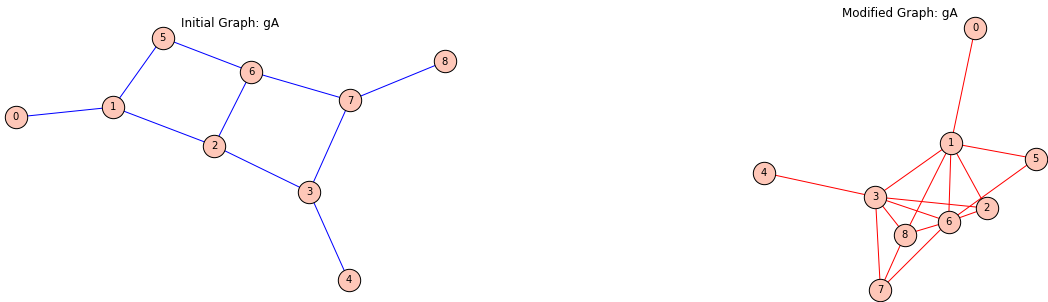

Graf: gB
Added edges: [(4, 6)]
Execution time: 0.7595 s




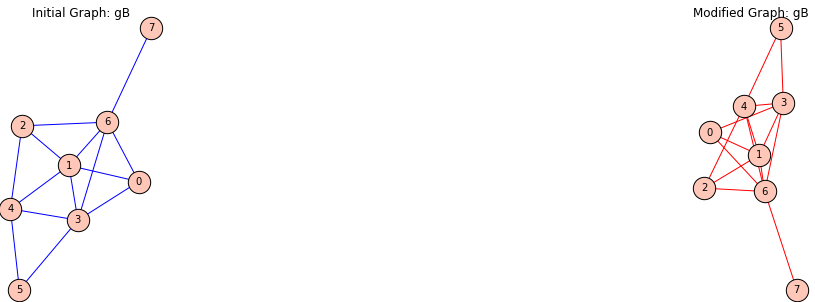

In [21]:
plot_ga('gA',Graph(gA))
plot_ga('gB',Graph(gB))

In [22]:
def grid_search_ga(G, population_sizes, num_generations, selection_methods, selection_map):
    results = {}
    
    for population_size in population_sizes:
        for num_gen in num_generations:
            for selection_method in selection_methods:
                
                start_time = time.time()
                
                tournament_size = 5
                if population_size > 20:
                    tournament_size = 15
                    if population_size > 80:
                        tournament_size = 30
                
                print(f"Calculating for population_size:{population_size}, num_gen:{num_gen}, selection_method:{selection_method}, tournament_size:{tournament_size}\n")
                best_individual, G_minimal = ga.genetic_algorithm(
                    G, 
                    population_size=population_size, 
                    num_generations=num_gen, 
                    mutation_rate=0.01, 
                    elitism_rate=0.1,
                    s=selection_method,
                    tournament_size=tournament_size
                    )
                
                end_time = time.time()
                execution_time = end_time - start_time
                
                #is_interval, _ = igc.check_interval_graph(G_minimal)
                
                if best_individual is not None:
                    added_edges = len(best_individual)
                else:
                    added_edges = np.nan
                
                results[(population_size, num_gen, selection_method)] = (added_edges, execution_time)

    return results

In [23]:
def plot_grid_search_ga(results, population_sizes, num_generations, selection_methods, selection_map, graph_name, folder_name):
    fig, axs = plt.subplots(2, len(selection_methods), figsize=(15, 10))
    
    for idx, selection_method in enumerate(selection_methods):
        added_edges_data = np.zeros((len(population_sizes), len(num_generations)))
        execution_time_data = np.zeros((len(population_sizes), len(num_generations)))

        for i, population_size in enumerate(population_sizes):
            for j, num_gen in enumerate(num_generations):
                added_edges, execution_time = results[(population_size, num_gen, selection_method)]
                
                # Use 0 for added_edges if it is NaN
                added_edges_data[i, j] = 0 if np.isnan(added_edges) else added_edges
                execution_time_data[i, j] = execution_time

        # Plot added edges
        im1 = axs[0, idx].imshow(added_edges_data, cmap='viridis', origin='lower')
        axs[0, idx].set_title(f'Added Edges (Selection: {selection_map[selection_method]})')
        axs[0, idx].set_xlabel('Num Generations')
        axs[0, idx].set_ylabel('Population Size')
        axs[0, idx].set_xticks(range(len(num_generations)))
        axs[0, idx].set_xticklabels(num_generations)
        axs[0, idx].set_yticks(range(len(population_sizes)))
        axs[0, idx].set_yticklabels(population_sizes)
        fig.colorbar(im1, ax=axs[0, idx])

        # Annotate added edges
        for i in range(len(population_sizes)):
            for j in range(len(num_generations)):
                value = added_edges_data[i, j]
                axs[0, idx].text(j, i, f'{value:.1f}', ha='center', va='center', 
                                 color='white' if value < np.nanmax(added_edges_data) / 2 else 'black')

        # Plot execution time
        im2 = axs[1, idx].imshow(execution_time_data, cmap='plasma', origin='lower')
        axs[1, idx].set_title(f'Execution Time (Selection: {selection_map[selection_method]})')
        axs[1, idx].set_xlabel('Num Generations')
        axs[1, idx].set_ylabel('Population Size')
        axs[1, idx].set_xticks(range(len(num_generations)))
        axs[1, idx].set_xticklabels(num_generations)
        axs[1, idx].set_yticks(range(len(population_sizes)))
        axs[1, idx].set_yticklabels(population_sizes)
        fig.colorbar(im2, ax=axs[1, idx])

        # Annotate execution time
        for i in range(len(population_sizes)):
            for j in range(len(num_generations)):
                value = execution_time_data[i, j]
                axs[1, idx].text(j, i, f'{value:.2f}', ha='center', va='center', 
                                 color='white' if value < np.max(execution_time_data) / 2 else 'black')

    plt.tight_layout()
    plt.savefig(f'{folder_name}/grid_search_results_{graph_name}.png', facecolor='white')
    plt.close()

In [24]:
def process_graphs(input_file, output_folder, population_sizes, num_generations, selection_methods, selection_map):
    graphs = read_graphs_from_json(input_file)

    results_text = []
    
    results_summary = []

    for graph_name, edges in graphs.items():
        print(f"Graph: {graph_name}")
        overall_start_time = time.time()
        
        G = Graph(edges)
        results = grid_search_ga(G, population_sizes, num_generations, selection_methods, selection_map)

        # Track the least added edges for the current graph
        least_added_edges = float('inf')
        best_params = None
        best_execution_time = None

        plot_grid_search_ga(results, population_sizes, num_generations, selection_methods, selection_map, graph_name, output_folder)

        results_text.append(f'Results for {graph_name}:\n')
        for key, (added_edges, execution_time) in results.items():
            if np.isnan(added_edges):
                results_text.append(f'Population: {key[0]}, Generations: {key[1]}, Selection: {selection_map[key[2]]}, '
                                    f'Added Edges: No added edges, Execution Time: {execution_time:.4f} s\n')
            else:
                results_text.append(f'Population: {key[0]}, Generations: {key[1]}, Selection: {selection_map[key[2]]}, '
                                    f'Added Edges: {added_edges}, Execution Time: {execution_time:.4f} s\n')

                # Update least added edges for the current graph if current is lower
                if added_edges < least_added_edges:
                    least_added_edges = added_edges
                    best_params = key
                    best_execution_time = execution_time

        # Append least added edges for the current graph to the results text
        results_text.append(f'Least Added Edges for {graph_name}: {least_added_edges}\n')
        if best_params:
            results_text.append(f'Best Parameters (Population, Generations, Selection): {best_params}\n')
            results_text.append(f'Execution Time for Best Result: {best_execution_time} s\n')
        results_text.append('\n')

        overall_end_time = time.time()
        overall_execution_time = overall_end_time - overall_start_time
        print(f"Execution time: {overall_execution_time}")
        print("---------------------------------------------------------")
        
        result_values = {
            'Graph' : graph_name,
            'Algorithm': "Genetic Algorithm",
            'Best Value': least_added_edges,
            'Execution Time': best_execution_time
        } 
        
        results_summary.append(result_values)

    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)  
    
    # Save results to text file
    results_file_path = os.path.join(output_folder, 'grid_search_results.txt')
    with open(results_file_path, 'w') as f:
        f.writelines(results_text)
        

    return results_summary

# Testing on small graphs

In [25]:
results_summary = []

#Brute Force
bf_small_input = './data/small_graphs.json'
bf_output = './results/small_graphs/brute_force/'

results_bf = process_graphs_bf(bf_small_input, bf_output)
results_summary.extend(results_bf)

#Simulated Annealing
sa_small_input = './data/small_graphs.json'
sa_small_output = './results/small_graphs/simulated_annealing/'

results_sa = plot_sa(sa_small_input, sa_small_output)
results_summary.extend(results_sa)

#Simulated Annealing - Cooling
sa_c_small_input = './data/small_graphs.json'
sa_c_small_output = './results/small_graphs/simulated_annealing_cooling/'

results_sa_c = process_graphs_sa_cooling(sa_c_small_input, sa_c_small_output, cooling_params)
results_summary.extend(results_sa_c)

#VNS
vns_small_input = './data/small_graphs.json'
vns_small_output = './results/small_graphs/vns/'

results_vns = process_graphs_vns(vns_small_input, vns_small_output)
results_summary.extend(results_vns)

#Genetic Algorithm
ga_small_input = './data/small_graphs.json'
ga_small_output = './results/small_graphs/genetic_algorithm/'

results_ga = process_graphs(ga_small_input, ga_small_output, population_sizes, num_generations, selection_methods, selection_map)
results_summary.extend(results_ga)

Processing Graph: g1
Graph: g1
Added edges: ((0, 2),)
Best value: 1
Execution time: 0.0068 s


Processing Graph: g2
Graph: g2
Added edges: ((1, 3),)
Best value: 1
Execution time: 0.1064 s


Processing Graph: g3
Graph: g3
Added edges: ((0, 3),)
Best value: 1
Execution time: 0.1057 s


Processing Graph: g4
Graph: g4
Added edges: ((3, 6),)
Best value: 1
Execution time: 3.4807 s


Processing Graph: i1
Graph: i1
Initial graph is already an interval graph
Execution time: 0.0002 s


Processing Graph: i2
Graph: i2
Initial graph is already an interval graph
Execution time: 0.0003 s


Processing Graph: i3
Graph: i3
Initial graph is already an interval graph
Execution time: 0.0002 s


Processing Graph: i4
Graph: i4
Initial graph is already an interval graph
Execution time: 0.0002 s


Processing Graph: i5
Graph: i5
Initial graph is already an interval graph
Execution time: 0.0003 s


Processing Graph: i6
Graph: i6
Initial graph is already an interval graph
Execution time: 0.0003 s


Processing gra

Calculating for population_size:50, num_gen:100, selection_method:r, tournament_size:15

Calculating for population_size:50, num_gen:100, selection_method:t, tournament_size:15

Calculating for population_size:50, num_gen:200, selection_method:r, tournament_size:15

Calculating for population_size:50, num_gen:200, selection_method:t, tournament_size:15

Calculating for population_size:100, num_gen:50, selection_method:r, tournament_size:30

Calculating for population_size:100, num_gen:50, selection_method:t, tournament_size:30

Calculating for population_size:100, num_gen:100, selection_method:r, tournament_size:30

Calculating for population_size:100, num_gen:100, selection_method:t, tournament_size:30

Calculating for population_size:100, num_gen:200, selection_method:r, tournament_size:30

Calculating for population_size:100, num_gen:200, selection_method:t, tournament_size:30

Execution time: 21.11761713027954
---------------------------------------------------------
Graph: g3
Calc

Execution time: 0.43622469902038574
---------------------------------------------------------
Graph: i4
Calculating for population_size:20, num_gen:50, selection_method:r, tournament_size:5

Calculating for population_size:20, num_gen:50, selection_method:t, tournament_size:5

Calculating for population_size:20, num_gen:100, selection_method:r, tournament_size:5

Calculating for population_size:20, num_gen:100, selection_method:t, tournament_size:5

Calculating for population_size:20, num_gen:200, selection_method:r, tournament_size:5

Calculating for population_size:20, num_gen:200, selection_method:t, tournament_size:5

Calculating for population_size:50, num_gen:50, selection_method:r, tournament_size:15

Calculating for population_size:50, num_gen:50, selection_method:t, tournament_size:15

Calculating for population_size:50, num_gen:100, selection_method:r, tournament_size:15

Calculating for population_size:50, num_gen:100, selection_method:t, tournament_size:15

Calculating for 

# Testing on random graphs

In [29]:
results_summary_random = []

#Simulated Annealing
sa_random_input = './data/random_graphs.json'
sa_random_output = './results/random_graphs/simulated_annealing/'

results_sa_random = plot_sa(sa_random_input, sa_random_output)
results_summary_random.extend(results_sa_random)

#Simulated Annealing - Cooling
sa_c_random_input = './data/random_graphs.json'
sa_c_random_output = './results/random_graphs/simulated_annealing_cooling/'

results_sa_c_random = process_graphs_sa_cooling(sa_c_random_input, sa_c_random_output, cooling_params)
results_summary_random.extend(results_sa_c_random)

#VNS
vns_random_input = './data/random_graphs.json'
vns_random_output = './results/random_graphs/vns/'

results_vns_random = process_graphs_vns(vns_random_input, vns_random_output)
results_summary_random.extend(results_vns_random)

#Genetic Algorithm
ga_random_input = './data/random_graphs.json'
ga_random_output = './results/random_graphs/genetic_algorithm/'

results_ga_random = process_graphs(ga_random_input, ga_random_output, population_sizes, num_generations, selection_methods, selection_map)
results_summary_random.extend(results_ga_random)

Processing graph: Graph1 with 9 nodes and 21 edge
Added edges: [(6, 7), (7, 8), (1, 8), (2, 8), (6, 8)]
Best value: 5
Execution time for Graph1 with 9 nodes and 21 edge: 15.2925 s
---------------------------------------------------------
Processing graph: Graph2 with 9 nodes and 21 edge
Added edges: [(1, 7), (1, 4), (4, 6), (4, 7), (3, 7), (6, 8)]
Best value: 6
Execution time for Graph2 with 9 nodes and 21 edge: 14.7493 s
---------------------------------------------------------
Processing graph: Graph with 6 nodes and 7 edges
Added edges: [(3, 5), (1, 5), (1, 3)]
Best value: 3
Execution time for Graph with 6 nodes and 7 edges: 10.9590 s
---------------------------------------------------------
Processing graph: Graph with 7 nodes and 12 edges
Added edges: [(1, 4), (1, 6)]
Best value: 2
Execution time for Graph with 7 nodes and 12 edges: 11.2987 s
---------------------------------------------------------
Processing graph: Graph with 7 nodes and 15 edges
Added edges: [(1, 4)]
Best value

Calculating for population_size:20, num_gen:100, selection_method:r, tournament_size:5

Calculating for population_size:20, num_gen:100, selection_method:t, tournament_size:5

Calculating for population_size:20, num_gen:200, selection_method:r, tournament_size:5

Calculating for population_size:20, num_gen:200, selection_method:t, tournament_size:5

Calculating for population_size:50, num_gen:50, selection_method:r, tournament_size:15

Calculating for population_size:50, num_gen:50, selection_method:t, tournament_size:15

Calculating for population_size:50, num_gen:100, selection_method:r, tournament_size:15

Calculating for population_size:50, num_gen:100, selection_method:t, tournament_size:15

Calculating for population_size:50, num_gen:200, selection_method:r, tournament_size:15

Calculating for population_size:50, num_gen:200, selection_method:t, tournament_size:15

Calculating for population_size:100, num_gen:50, selection_method:r, tournament_size:30

Calculating for population_

Calculating for population_size:100, num_gen:200, selection_method:t, tournament_size:30

Execution time: 27.94465208053589
---------------------------------------------------------
Graph: Graph with 8 nodes and 15 edges
Calculating for population_size:20, num_gen:50, selection_method:r, tournament_size:5

Calculating for population_size:20, num_gen:50, selection_method:t, tournament_size:5

Calculating for population_size:20, num_gen:100, selection_method:r, tournament_size:5

Calculating for population_size:20, num_gen:100, selection_method:t, tournament_size:5

Calculating for population_size:20, num_gen:200, selection_method:r, tournament_size:5

Calculating for population_size:20, num_gen:200, selection_method:t, tournament_size:5

Calculating for population_size:50, num_gen:50, selection_method:r, tournament_size:15

Calculating for population_size:50, num_gen:50, selection_method:t, tournament_size:15

Calculating for population_size:50, num_gen:100, selection_method:r, tourname

Calculating for population_size:100, num_gen:50, selection_method:t, tournament_size:30

Calculating for population_size:100, num_gen:100, selection_method:r, tournament_size:30

Calculating for population_size:100, num_gen:100, selection_method:t, tournament_size:30

Calculating for population_size:100, num_gen:200, selection_method:r, tournament_size:30

Calculating for population_size:100, num_gen:200, selection_method:t, tournament_size:30

Execution time: 32.05414938926697
---------------------------------------------------------
Graph: Graph with 10 nodes and 20 edges
Calculating for population_size:20, num_gen:50, selection_method:r, tournament_size:5

Calculating for population_size:20, num_gen:50, selection_method:t, tournament_size:5

Calculating for population_size:20, num_gen:100, selection_method:r, tournament_size:5

Calculating for population_size:20, num_gen:100, selection_method:t, tournament_size:5

Calculating for population_size:20, num_gen:200, selection_method:r, 

# Testing on big graphs

In [32]:
population_sizes_big = [20, 50, 100]
num_generations_big = [50, 100, 200]
selection_methods_big = ['r', 't']  # 'r' for roulette, 't' for tournament
selection_map_big = {
    'r': 'Roulette',
    't': 'Tournament'
}

In [33]:
#Graph with 20 nodes
g20_results = []

#Simulated Annealing
sa_g20_input = './data/g20.json'
sa_g20_output = './results/big_graphs/simulated_annealing/'

results_sa_g20 = plot_sa(sa_g20_input, sa_g20_output)
g20_results.extend(results_sa_g20)

#Simulated Annealing - Cooling
sa_c_g20_input = './data/g20.json'
sa_c_g20_output = './results/big_graphs/simulated_annealing_cooling/'

results_sa_c_g20 = process_graphs_sa_cooling(sa_c_g20_input, sa_c_g20_output, cooling_params)
g20_results.extend(results_sa_c_g20)

#VNS
vns_g20_input = './data/g20.json'
vns_g20_output = './results/big_graphs/vns/'

results_vns_g20 = process_graphs_vns(vns_g20_input, vns_g20_output)
g20_results.extend(results_vns_g20)

#Genetic Algorithm
ga_g20_input = './data/g20.json'
ga_g20_output = './results/big_graphs/genetic_algorithm/'

results_ga_g20 = process_graphs(ga_g20_input, ga_g20_output, population_sizes_big , num_generations_big , selection_methods_big , selection_map_big)
g20_results.extend(results_ga_g20)

Processing graph: Graph with 20 nodes
No interval graph found
Execution time for Graph with 20 nodes: 40.2850 s
---------------------------------------------------------
Processing Graph: Graph with 20 nodes
Simulated annealing - cooling for graph: Graph with 20 nodes
Execution time for Graph with 20 nodes: 527.5222 s
---------------------------------------------------------
Processing Graph: Graph with 20 nodes
VNS
Time limit: 15
Time limit: 30
Time limit: 45
Execution time for Graph with 20 nodes: 91.4354 s
---------------------------------------------------------
Graph: Graph with 20 nodes
Calculating for population_size:20, num_gen:50, selection_method:r, tournament_size:5

Calculating for population_size:20, num_gen:50, selection_method:t, tournament_size:5

Calculating for population_size:20, num_gen:100, selection_method:r, tournament_size:5

Calculating for population_size:20, num_gen:100, selection_method:t, tournament_size:5

Calculating for population_size:20, num_gen:200, s

In [40]:
#Graph with 30 nodes
g30_results = []

#Simulated Annealing
sa_g30_input = './data/g30.json'
sa_g30_output = './results/big_graphs/simulated_annealing/'

results_sa_g30 = plot_sa(sa_g30_input, sa_g30_output)
g30_results.extend(results_sa_g30)

#Simulated Annealing - Cooling
sa_c_g30_input = './data/g30.json'
sa_c_g30_output = './results/big_graphs/simulated_annealing_cooling/'

results_sa_c_g30 = process_graphs_sa_cooling(sa_c_g30_input, sa_c_g30_output, cooling_params)
g30_results.extend(results_sa_c_g30)

#VNS
vns_g30_input = './data/g30.json'
vns_g30_output = './results/big_graphs/vns/'

results_vns_g30 = process_graphs_vns(vns_g30_input, vns_g30_output)
g30_results.extend(results_vns_g30)

#Genetic Algorithm
ga_g30_input = './data/g30.json'
ga_g30_output = './results/big_graphs/genetic_algorithm/'

results_ga_g30 = process_graphs(ga_g30_input, ga_g30_output, population_sizes_big , num_generations_big , selection_methods_big , selection_map_big)
g30_results.extend(results_ga_g30)

Processing graph: Graph with 30 nodes
No interval graph found
Execution time for Graph with 30 nodes: 73.8462 s
---------------------------------------------------------
Processing Graph: Graph with 30 nodes
Simulated annealing - cooling for graph: Graph with 30 nodes
Execution time for Graph with 30 nodes: 1003.3559 s
---------------------------------------------------------
Processing Graph: Graph with 30 nodes
VNS
Time limit: 15
Time limit: 30
Time limit: 45
Execution time for Graph with 30 nodes: 94.8135 s
---------------------------------------------------------
Graph: Graph with 30 nodes
Calculating for population_size:20, num_gen:50, selection_method:r, tournament_size:5

Calculating for population_size:20, num_gen:50, selection_method:t, tournament_size:5

Calculating for population_size:20, num_gen:100, selection_method:r, tournament_size:5

Calculating for population_size:20, num_gen:100, selection_method:t, tournament_size:5

Calculating for population_size:20, num_gen:200, 

In [43]:
#Graph with 50 nodes
g50_results = []

#Simulated Annealing
sa_g50_input = './data/g50.json'
sa_g50_output = './results/big_graphs/simulated_annealing/'

results_sa_g50 = plot_sa(sa_g50_input, sa_g50_output)
g50_results.extend(results_sa_g50)

#Simulated Annealing - Cooling
sa_c_g50_input = './data/g50.json'
sa_c_g50_output = './results/big_graphs/simulated_annealing_cooling/'

results_sa_c_g50 = process_graphs_sa_cooling(sa_c_g50_input, sa_c_g50_output, cooling_params)
g50_results.extend(results_sa_c_g50)

#VNS
vns_g50_input = './data/g50.json'
vns_g50_output = './results/big_graphs/vns/'

results_vns_g50 = process_graphs_vns(vns_g50_input, vns_g50_output)
g50_results.extend(results_vns_g50)

#Genetic Algorithm
ga_g50_input = './data/g50.json'
ga_g50_output = './results/big_graphs/genetic_algorithm/'

results_ga_g50 = process_graphs(ga_g50_input, ga_g50_output, population_sizes_big , num_generations_big , selection_methods_big , selection_map_big)
g50_results.extend(results_ga_g50)

Processing graph: Graph with 50 nodes
No interval graph found
Execution time for Graph with 50 nodes: 215.9803 s
---------------------------------------------------------
Processing Graph: Graph with 50 nodes
Simulated annealing - cooling for graph: Graph with 50 nodes
Execution time for Graph with 50 nodes: 2634.8844 s
---------------------------------------------------------
Processing Graph: Graph with 50 nodes
VNS
Time limit: 15
Time limit: 30
Time limit: 45
Execution time for Graph with 50 nodes: 102.9774 s
---------------------------------------------------------
Graph: Graph with 50 nodes
Calculating for population_size:20, num_gen:50, selection_method:r, tournament_size:5

Calculating for population_size:20, num_gen:50, selection_method:t, tournament_size:5

Calculating for population_size:20, num_gen:100, selection_method:r, tournament_size:5

Calculating for population_size:20, num_gen:100, selection_method:t, tournament_size:5

Calculating for population_size:20, num_gen:200

# Plot summary

In [27]:
def plot_graph_results(results_df, output_folder, filename):
    # Sort DataFrame by Graph and Algorithm
    df = results_df.sort_values(by=['Graph', 'Algorithm'])

    # Replace NaN, None, inf with 0 for plotting
    df['Best Value'] = df['Best Value'].replace([None, np.nan, np.inf], 0)
    df['Execution Time'] = df['Execution Time'].replace([None, np.nan, np.inf], 0)

    # Create a list of unique graphs
    graphs = df['Graph'].unique()

    # Number of graphs
    num_graphs = len(graphs)

    # Create a color map for each graph
    colors = cm.get_cmap('tab10', num_graphs)

    # Create subplots: 2 plots (Best Value and Execution Time) per graph
    fig, axes = plt.subplots(num_graphs, 2, figsize=(15, num_graphs * 6), facecolor='white')

    # Iterate over each graph to plot Best Value and Execution Time
    for i, graph in enumerate(graphs):
        # Filter data for the current graph
        graph_data = df[df['Graph'] == graph]
        
        # Get x positions and width for the bars
        x = np.arange(len(graph_data))  # the label locations
        width = 0.35  # width of the bars
        
        # Plot Best Value
        axes[i, 0].bar(graph_data['Algorithm'], graph_data['Best Value'], 
                        width, color=colors(i))
        axes[i, 0].set_title(f'Best Value for Graph {graph}')
        axes[i, 0].set_ylabel('Best Value')
        axes[i, 0].set_xticks(x)
        axes[i, 0].set_xticklabels(graph_data['Algorithm'], rotation=45, ha='right')
        
        # Plot Execution Time
        axes[i, 1].bar(graph_data['Algorithm'], graph_data['Execution Time'], 
                        width, color=colors(i))
        axes[i, 1].set_title(f'Execution Time for Graph {graph}')
        axes[i, 1].set_ylabel('Execution Time (s)')
        axes[i, 1].set_xticks(x)
        axes[i, 1].set_xticklabels(graph_data['Algorithm'], rotation=45, ha='right')

        # Add legend with only algorithm names
        axes[i, 0].legend(graph_data['Algorithm'].unique(), title='Algorithm')
        axes[i, 1].legend(graph_data['Algorithm'].unique(), title='Algorithm')

        # Set grid and background color for axes
        axes[i, 0].grid(axis='y', color='grey', linestyle='--', linewidth=0.7, alpha=0.7)
        axes[i, 1].grid(axis='y', color='grey', linestyle='--', linewidth=0.7, alpha=0.7)

        # Set background color to white
        axes[i, 0].set_facecolor('white')
        axes[i, 1].set_facecolor('white')

    # Adjust layout
    plt.tight_layout()

    # Save the plot as PNG in the specified output folder
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    plt.savefig(os.path.join(output_folder, f"{filename}.png"), facecolor='white')
    
    # Show the plot
    plt.show()

/tmp/ipykernel_7226/3077079021.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Execution Time'] = df['Execution Time'].replace([None, np.nan, np.inf], Integer(0))


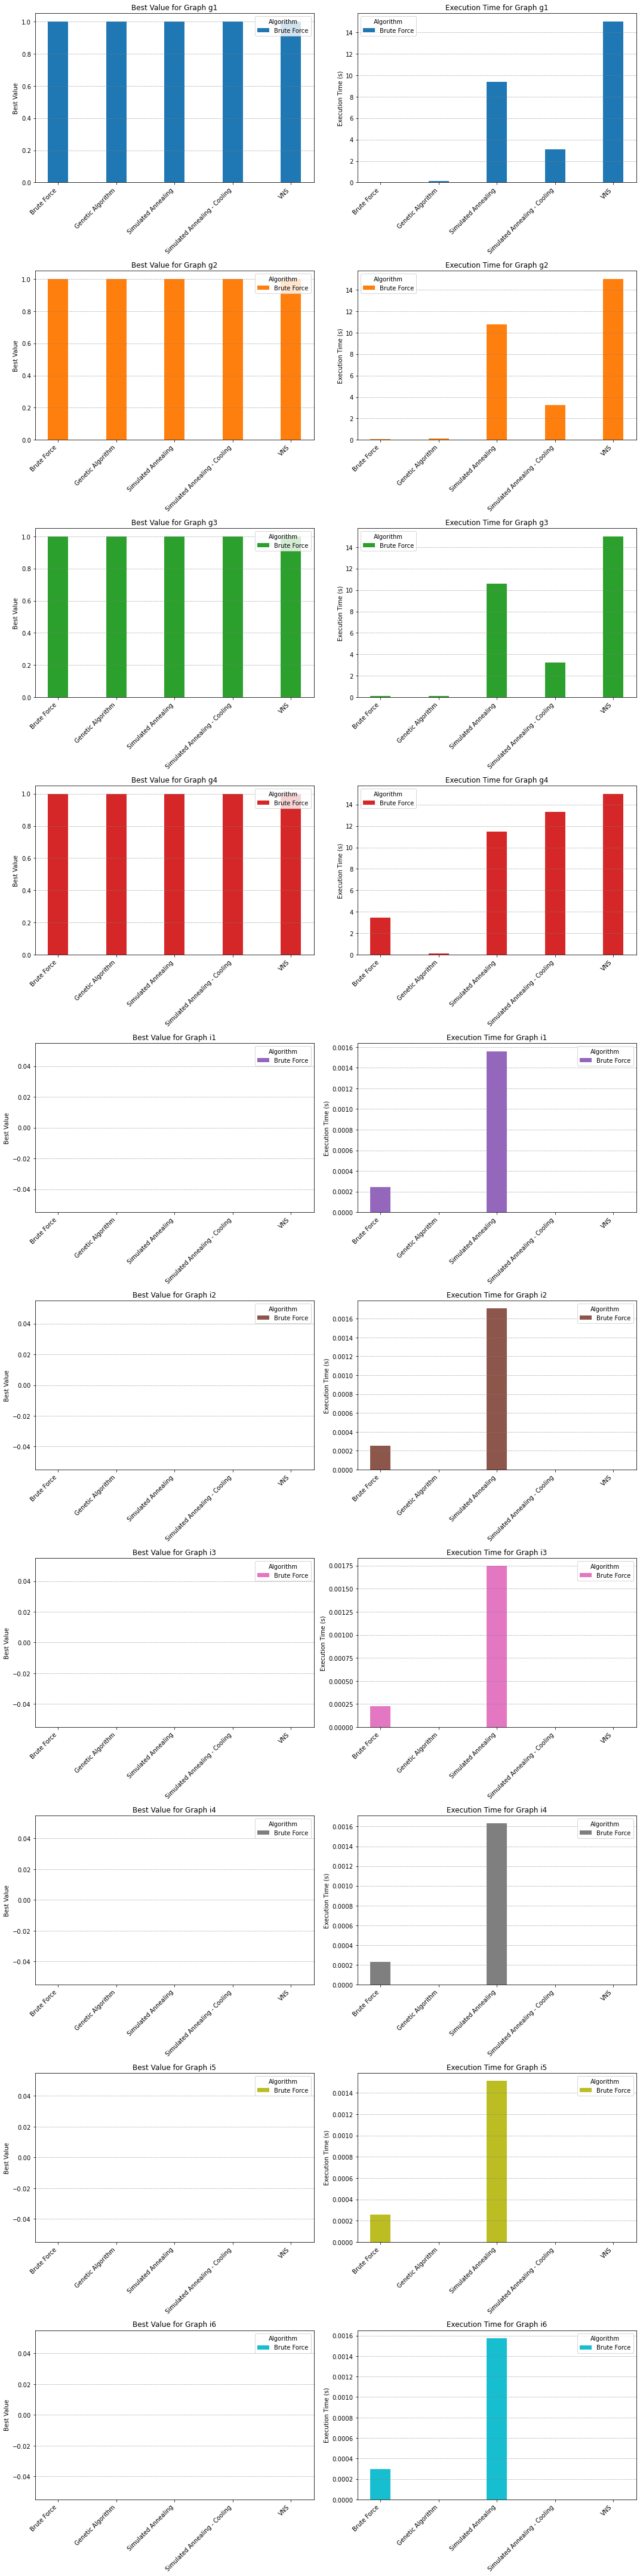

In [28]:
df_small = pd.DataFrame(results_summary)
plot_graph_results(df_small, './results/small_graphs/', 'overall_graph_results')

/tmp/ipykernel_7226/3077079021.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Execution Time'] = df['Execution Time'].replace([None, np.nan, np.inf], Integer(0))


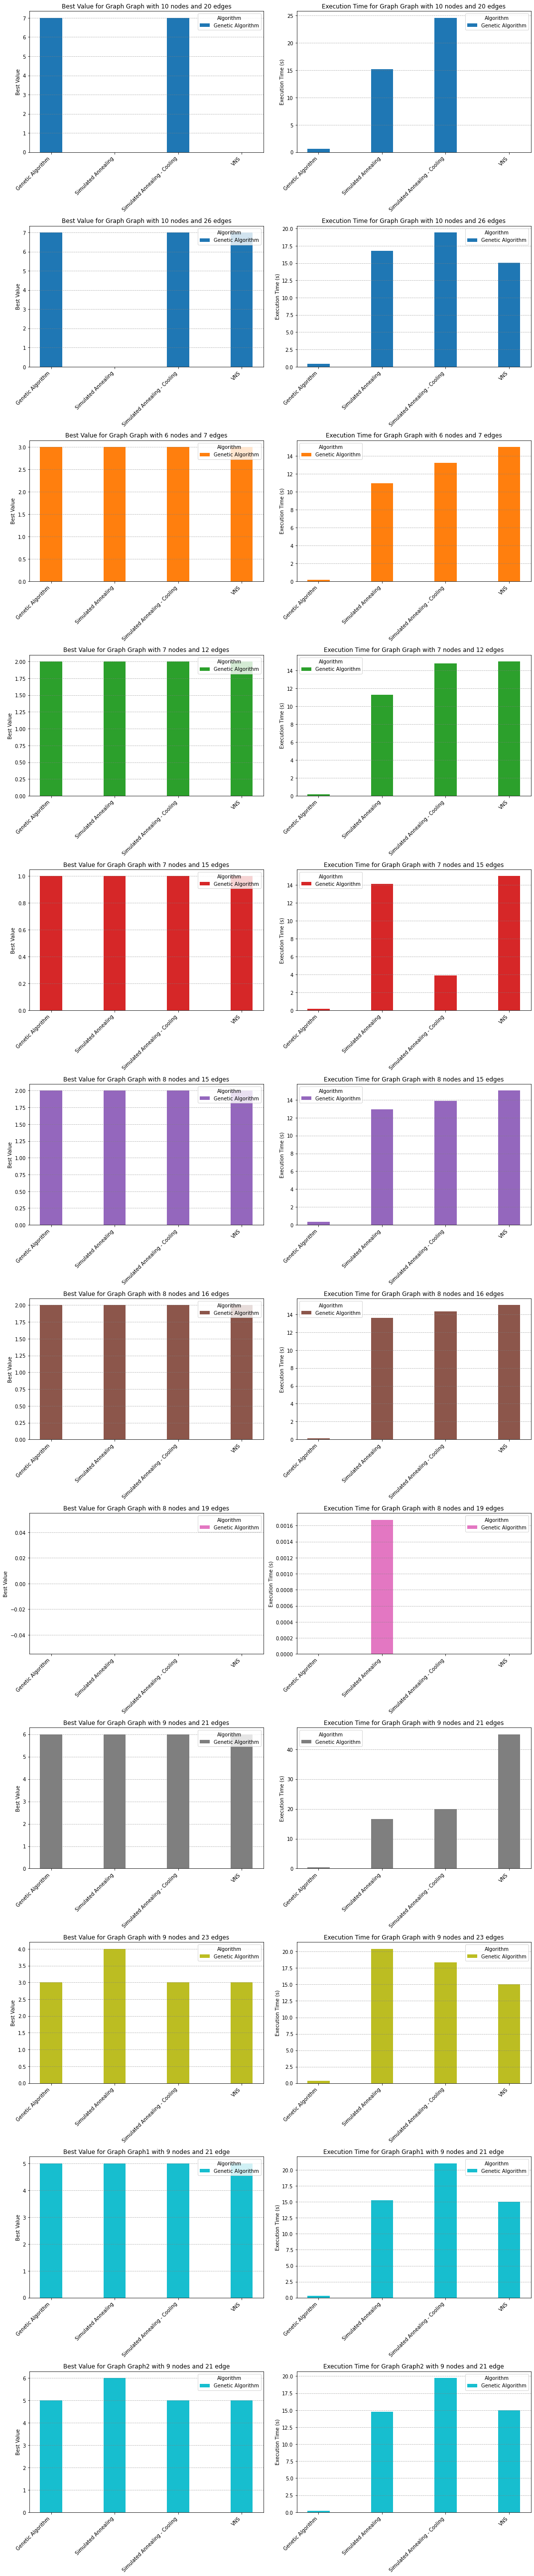

In [31]:
df_random = pd.DataFrame(results_summary_random)
plot_graph_results(df_random, './results/random_graphs/', 'overall_graph_results')

In [37]:
df_g20 = pd.DataFrame(g20_results)
df_g20

,Graph,Algorithm,Best Value,Execution Time
0,Graph with 20 nodes,Simulated Annealing,inf,40.284965
1,Graph with 20 nodes,Simulated Annealing - Cooling,43.0,54.108013
2,Graph with 20 nodes,VNS,inf,NaN
3,Graph with 20 nodes,Genetic Algorithm,43.0,7.323347


In [41]:
df_g30 = pd.DataFrame(g30_results)
df_g30

,Graph,Algorithm,Best Value,Execution Time
0,Graph with 30 nodes,Simulated Annealing,inf,73.846219
1,Graph with 30 nodes,Simulated Annealing - Cooling,138.0,109.957590
2,Graph with 30 nodes,VNS,inf,NaN
3,Graph with 30 nodes,Genetic Algorithm,157.0,7.235888


In [44]:
df_g50 = pd.DataFrame(g50_results)
df_g50

,Graph,Algorithm,Best Value,Execution Time
0,Graph with 50 nodes,Simulated Annealing,inf,215.980289
1,Graph with 50 nodes,Simulated Annealing - Cooling,403.0,299.023929
2,Graph with 50 nodes,VNS,inf,NaN
3,Graph with 50 nodes,Genetic Algorithm,878.0,36.100909
